In [51]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport

#read in who_life_exp.csv
df = pd.read_csv('who_life_exp.csv')
df.head()

,country,country_code,region,year,life_expect,life_exp60,adult_mortality,infant_mort,age1-4mort,alcohol,...,che_gdp,une_pop,une_infant,une_life,une_hiv,une_gni,une_poverty,une_edu_spend,une_literacy,une_school
0,Angola,AGO,Africa,2000,47.33730,14.73400,383.5583,0.137985,0.025695,1.47439,...,1.90860,16395.473,122.2,46.522,1.0,2530.0,32.3,2.60753,NaN,NaN
1,Angola,AGO,Africa,2001,48.19789,14.95963,372.3876,0.133675,0.024500,1.94025,...,4.48352,16945.753,118.9,47.059,1.1,2630.0,NaN,NaN,67.40542,NaN
2,Angola,AGO,Africa,2002,49.42569,15.20010,354.5147,0.128320,0.023260,2.07512,...,3.32946,17519.417,115.1,47.702,1.2,3180.0,NaN,NaN,NaN,NaN
3,Angola,AGO,Africa,2003,50.50266,15.39144,343.2169,0.122040,0.021925,2.20275,...,3.54797,18121.479,110.8,48.440,1.3,3260.0,NaN,NaN,NaN,NaN
4,Angola,AGO,Africa,2004,51.52863,15.56860,333.8711,0.115700,0.020545,2.41274,...,3.96720,18758.145,106.2,49.263,1.3,3560.0,NaN,NaN,NaN,NaN


In [3]:
#Create profile for EDA, optional
profile = ProfileReport(df, title='Pandas Profiling Report', minimal=True, correlations={"pearson": {"calculate": True}})
profile.to_file("life_exp_eda.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 199.77it/s]


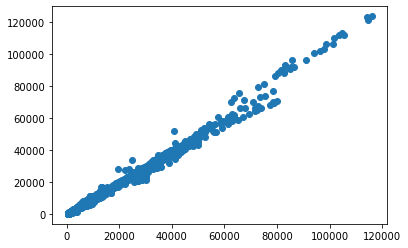

In [23]:
plt.scatter(df['une_gni'],df['gni_capita'])

### Feature removal and decorrelation

In [52]:
#Based on EDA, the following features are basically the same thing as life expectancy and should be removed
bad_features = ['une_infant', 'une_life', 'country_code']
df = df.drop(columns=bad_features)

#The following features are highly correlated with the target. We may consider trying models with or without these features
highly_correlated_features = ['adult_mortality', 'infant_mort']

#The columns 'diptheria', 'polio', and 'measles' are essentially measuring the same thing and will be averaged under a new column 'diseases'
df['diseases'] = (df['diphtheria'] + df['polio'] + df['measles']) / 3

#The features 'une_gni' and 'gni_capita' are virtually the same feature and the latter will be removed.
df = df.drop(columns=['gni_capita'])

### One-hot-encoding of categorial feature 'region'

In [121]:
df = pd.get_dummies(df, columns=['region'])

### Missing value imputation
For the purpose of this analysis we care about modeling a single year for every country. This is because if we include multiple years of the same country as observations, the observations will be highly correlated. So it is better if we simply fit a model to the 200 some-odd points where each country only appears once. Furthermore, it does not really matter that all observations come from the same year, as we only need a "snapshot" of a country at some point in time. Besides, countries are individually on different stages of development so the hypothetical restriction of observations to a single year is completely arbitrary. From a statistical point of view, we only need samples from the joint distribution of covariates, for which any year (independently) will suffice. 

As such, we would like to select, for each country, the year with the fewest number of missing values. We will then impute the remaining missing values based on the last non-null entry for that covariate.

In [122]:
#Find indexes of 'best' rows for each country
best_rows = df.groupby('country').apply(lambda x: x.isna().sum(axis=1).idxmin())

#Fill all of the NaNs using the closest non-NaN entry. Uses alternating forward and backward fill until all NaNs are removed.
country_col = df['country']

for i in range(20):
    if i == 0:
        df_filled = df.groupby('country').fillna(method='ffill', limit=1)
        df_filled['country'] = country_col
        df_filled = df_filled.groupby('country').fillna(method='bfill', limit=1)
        df_filled['country'] = country_col
    else:
        df_filled = df_filled.groupby('country').fillna(method='ffill', limit=1)
        df_filled['country'] = country_col
        df_filled = df_filled.groupby('country').fillna(method='bfill', limit=1)
        df_filled['country'] = country_col

In [123]:
best_observations = df_filled.loc[best_rows]

### EDA of imputed data

In [64]:
profile = ProfileReport(best_observations, title='Pandas Profiling Report', minimal=True, correlations={"pearson": {"calculate": True}})
profile.to_file("life_expect_best_rows.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 199.82it/s]


### Further NaN handling
There are still missing values. Based on the above EDA, the features with missing values can be split cleanly into two categories: features where only a small (<2%) of countries have missing data, and features where many (>20%) have missing data. It is easy to simply drop the former since it will not significantly impact the number of observations and this takes care of most of the missing values. Then, we can 

* Try regressions on this set of data with reduced number of features (only the ones without missing values). This gives a larger number of observations with fewer features
* Try regressions on only the observations without missing values (but all observations). This gives a larger number of features with fewer observations

In [124]:
few_missing_value_feats = ['alcohol', 'bmi', 'age5-19thinness', 'age5-19obesity', 'hepatitis', 'doctors', 'gghe-d', 'che_gdp', 'une_gni']
many_missing_value_feats = ['hospitals', 'une_hiv', 'une_poverty', 'une_edu_spend', 'une_literacy', 'une_school']

In [125]:
# The first approach, this gives 165 observations, with 26 potential features
obs_full = best_observations.dropna(subset=few_missing_value_feats)
obs_full_obs = obs_full.drop(columns=many_missing_value_feats)
obs_full_obs

,year,life_expect,life_exp60,adult_mortality,infant_mort,age1-4mort,alcohol,bmi,age5-19thinness,age5-19obesity,...,une_pop,une_gni,diseases,region_Africa,region_Americas,region_Eastern Mediterranean,region_Europe,region_South-East Asia,region_Western Pacific,country
1371,2011,61.72234,16.01989,248.1654,0.067105,0.006270,0.00992,22.8,18.4,2.0,...,30117.413,1620.0,66.666667,0,0,1,0,0,0,Afghanistan
603,2008,74.80502,21.01600,108.3998,0.024880,0.001095,0.37239,24.9,6.0,9.0,...,34730.608,12120.0,91.000000,1,0,0,0,0,0,Algeria
14,2014,61.67921,17.21005,243.9467,0.063120,0.008560,7.48675,23.2,8.6,2.0,...,26941.779,6760.0,55.333333,1,0,0,0,0,0,Angola
817,2001,73.02618,19.13280,154.4558,0.011640,0.000445,6.85232,25.2,3.6,5.3,...,77.212,15330.0,97.666667,0,1,0,0,0,0,Antigua and Barbuda
812,2013,76.31533,21.44949,116.4624,0.011435,0.000355,8.20306,27.4,0.9,15.7,...,42196.030,19930.0,92.666667,0,1,0,0,0,0,Argentina
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902,2001,72.13280,20.29395,174.5862,0.017980,0.000795,8.15050,26.3,1.8,10.1,...,24646.472,11840.0,85.000000,0,1,0,0,0,0,Venezuela (Bolivarian Republic of)
2865,2009,75.28961,22.02871,133.1758,0.018500,0.001205,1.96956,20.9,15.0,0.9,...,87092.252,3560.0,96.666667,0,0,0,0,0,1,Viet Nam
1517,2004,62.46558,15.97963,247.6339,0.059785,0.005360,0.06000,22.7,13.9,2.9,...,19540.098,3230.0,72.666667,0,0,1,0,0,0,Yemen
163,2010,57.54378,16.74589,363.5941,0.057145,0.007990,3.58587,22.2,6.7,1.8,...,13605.984,3050.0,86.333333,1,0,0,0,0,0,Zambia


In [126]:
# The second approach, this gives 61 observations, with 32 potential features
mask = best_observations.notnull().all(axis=1)
obs_full_features = best_observations.loc[mask]

In [127]:
obs_full_features

,year,life_expect,life_exp60,adult_mortality,infant_mort,age1-4mort,alcohol,bmi,age5-19thinness,age5-19obesity,...,une_literacy,une_school,diseases,region_Africa,region_Americas,region_Eastern Mediterranean,region_Europe,region_South-East Asia,region_Western Pacific,country
1735,2001,72.18071,18.96136,143.15140,0.028865,0.000935,2.86603,25.7,2.1,2.6,...,99.40016,10.45174,94.666667,0,0,0,1,0,0,Armenia
2580,2013,71.37015,19.23323,137.97630,0.034120,0.002065,0.00402,21.4,18.7,2.0,...,61.01554,5.08167,94.333333,0,0,0,0,1,0,Bangladesh
2525,2009,70.17339,17.48758,225.22220,0.004495,0.000350,13.98003,26.3,2.2,5.3,...,99.61706,11.33366,97.666667,0,0,0,1,0,0,Belarus
36,2002,56.10347,16.42120,283.68710,0.091855,0.014550,1.34153,22.3,9.5,1.0,...,34.65785,2.46291,72.333333,1,0,0,0,0,0,Benin
2596,2012,69.20242,20.07917,222.02600,0.031530,0.001815,0.29944,23.5,16.6,2.3,...,57.03360,2.22245,96.333333,0,0,0,0,1,0,Bhutan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,2011,58.61579,14.89114,290.52180,0.060545,0.008140,1.13957,23.2,7.3,1.4,...,60.40994,3.65156,80.666667,1,0,0,0,0,0,Togo
1506,2010,74.89726,19.52879,99.42535,0.015465,0.000645,1.25903,25.9,6.3,6.2,...,79.13058,6.70267,97.666667,0,0,1,0,0,0,Tunisia
131,2012,59.47330,16.94417,335.35090,0.049225,0.006405,8.38765,22.1,5.9,1.2,...,70.19822,5.12872,80.666667,1,0,0,0,0,0,Uganda
1002,2016,77.06158,22.29529,113.93880,0.011750,0.000565,5.52664,27.4,1.5,13.8,...,98.56147,8.71883,95.000000,0,1,0,0,0,0,Uruguay


##### A final approach is to use KNN to impute missing values. This way we can fit to all 182 observations with all 32 potential features.

In [129]:
from sklearn.impute import KNNImputer

df_temp = best_observations.drop(columns=['year','life_expect','country'])
imputer = KNNImputer(n_neighbors=2)
imputed_data = imputer.fit_transform(df_temp)
obs_imputed = pd.DataFrame(imputed_data, columns=df_temp.columns)

#add back non-numeric columns
for col in ['year','life_expect','country']:
    obs_imputed[col] = list(best_observations[col])

In summary we now have 3 fully non-NaN datasets to use:

* obs_full_obs, a dataset that contains most observations and most features
* obs_full_features, a dataset that contains some observations and all features
* obs_imputed, a dataset that includes all observations and all features but is potentially less accurate as it used KNN on up to 30% of some features.

### Feature tranformations

In [168]:
#Based on EDA, the features to be log-transformed
log_features = ['une_poverty', 'une_gni', 'une_hiv', 'une_pop', 'age1-4mort', 'infant_mort']
log_features_full_obs = ['une_pop', 'age1-4mort', 'infant_mort']

#Transform these features (keeping the old feature) for each of our 3 datasets
for feat in log_features:
    obs_full_features[f'log_{feat}'] = np.log(obs_full_features[feat])
    obs_imputed[f'log_{feat}'] = np.log(obs_imputed[feat])

for feat in log_features_full_obs:
    obs_full_obs[f'log_{feat}'] = np.log(obs_full_obs[feat])

C:\Users\Spencer\AppData\Local\Temp\ipykernel_35428\1738252845.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_full_features[f'log_{feat}'] = np.log(obs_full_features[feat])


### DONE WITH PREPARING DATA WOOOOOOOOO

# Modeling

In [143]:
import statsmodels.api as sm

def fit_ols(data, predictors = None, drops = None):
    data = data.drop(columns = ['year','country'])

    y = data['life_expect']
    if predictors is not None:
        X = data[predictors]
    elif drops is not None:
        X = data.drop(columns=drops)
        X = X.drop(columns= ['life_expect'])
    else:
        X = data.drop(columns = ['life_expect'])

    X = sm.add_constant(X)
    X = np.asarray(X.astype(float))
    y = np.asarray(y.astype(float))

    model = sm.OLS(y, X).fit()

    return model

In [154]:
model1 = fit_ols(obs_full_obs, drops = highly_correlated_features)
model2 = fit_ols(obs_full_features, drops = highly_correlated_features)
model3 = fit_ols(obs_imputed, drops = highly_correlated_features)

### Try forward and backward selection with AIC as the criterion

In [201]:
# define function for calculating AIC
def get_aic(model):
    return model.aic

# define function for backward feature selection with AIC
def backward_selection_aic(X, y):
    selected = set(X.columns)
    current_score, best_new_score = float('inf'), float('inf')
    while X.shape[1] > 0:
        scores_with_candidates = []
        for candidate in X.columns:
            if candidate in selected:
                model = sm.OLS(y, sm.add_constant(X[list(selected-set([candidate]))])).fit()
                aic = get_aic(model)
                scores_with_candidates.append((aic, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates[0]
        if best_new_score < current_score:
            selected.remove(best_candidate)
            current_score = best_new_score
        else:
            break
    model = sm.OLS(y, sm.add_constant(X[list(selected)])).fit()
    return model

In [200]:
# define function for calculating AIC
def get_aic(model):
    return model.aic

# define function for forward feature selection with AIC
def forward_selection_aic(X, y):
    selected = set()
    current_score, best_new_score = float('inf'), float('inf')
    while X.shape[1] > 0:
        scores_with_candidates = []
        for candidate in X.columns:
            if candidate not in selected:
                model = sm.OLS(y, sm.add_constant(X[list(selected)+[candidate]])).fit()
                bic = get_aic(model)
                scores_with_candidates.append((bic, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates[0]
        if best_new_score < current_score:
            selected.add(best_candidate)
            current_score = best_new_score
        else:
            break
    model = sm.OLS(y, sm.add_constant(X[list(selected)])).fit()
    return model

In [175]:
X = obs_imputed.drop(columns = ['year','country'])
y = obs_imputed['life_expect']

#Also drop the closely related features like infant mortality, etc
X = X.drop(columns=highly_correlated_features)
X = X.drop(columns= ['life_expect'])
X = X.drop(columns= ['life_exp60'])
X = X.drop(columns=['une_poverty', 'une_gni', 'une_hiv', 'une_pop', 'age1-4mort'])
X = X.drop(columns=['log_infant_mort','log_age1-4mort'])

In [204]:
mod_aic_backward= backward_selection_aic(X,y)
mod_aic_forward= forward_selection_aic(X,y)

In [205]:
mod_aic_backward.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            life_expect   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     84.47
Date:                Tue, 02 May 2023   Prob (F-statistic):           1.04e-69
Time:                        23:16:04   Log-Likelihood:                -455.41
No. Observations:                 183   AIC:                             942.8
Df Residuals:                     167   BIC:                             994.2
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           44.2470      5.590      7.916      0.000      33.211      55.283
polio                            0.0484      0.071      0.685      0.494      -0.091       0.188
region_Europe                    7.4115      1.276      5.810      0.000       4.893       9.930
region_Western Pacific           8.8458      1.070      8.268      0.000       6.734      10.958
region_Eastern Mediterranean     5.7100      1.396      4.089      0.000       2.953       8.467
region_South-East Asia           8.9900      1.357      6.624      0.000       6.311      11.669
age5-19thinness                 -0.2822      0.099     -2.845      0.005      -0.478      -0.086
age5-19obesity                   0.2990      0.114      2.619      0.010       0.074       0.525
diseases                         0.0234      0.006      4.009      0.000       0.012       0.035
log_une_gni                      1.8670      0.389      4.798      0.000       1.099       2.635
diphtheria                       0.0804      0.069      1.160      0.248      -0.056       0.217
bmi                             -0.7126      0.244     -2.923      0.004      -1.194      -0.231
region_Americas                  8.3503      1.080      7.730      0.000       6.218      10.483
measles                         -0.0586      0.047     -1.237      0.218      -0.152       0.035
region_Africa                    4.9395      1.047      4.716      0.000       2.871       7.008
gghe-d                           0.3685      0.163      2.266      0.025       0.047       0.690
log_une_hiv                     -1.4014      0.228     -6.141      0.000      -1.852      -0.951
basic_water                      0.1069      0.030      3.608      0.000       0.048       0.165
==============================================================================
Omnibus:                        4.499   Durbin-Watson:                   2.092
Prob(Omnibus):                  0.105   Jarque-Bera (JB):                4.057
Skew:                          -0.329   Prob(JB):                        0.132
Kurtosis:                       3.316   Cond. No.                     2.09e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.65e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [206]:
mod_aic_forward.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            life_expect   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     127.1
Date:                Tue, 02 May 2023   Prob (F-statistic):           5.69e-74
Time:                        23:16:11   Log-Likelihood:                -457.56
No. Observations:                 183   AIC:                             937.1
Df Residuals:                     172   BIC:                             972.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           55.7245      6.231      8.943      0.000      43.425      68.023
region_Eastern Mediterranean    -2.5881      0.920     -2.812      0.005      -4.405      -0.771
bmi                             -0.8176      0.231     -3.546      0.001      -1.273      -0.363
age5-19thinness                 -0.2336      0.081     -2.868      0.005      -0.394      -0.073
region_Africa                   -3.5001      0.831     -4.209      0.000      -5.141      -1.859
age5-19obesity                   0.3815      0.099      3.860      0.000       0.186       0.577
gghe-d                           0.3350      0.155      2.157      0.032       0.029       0.641
log_une_hiv                     -1.3042      0.217     -6.015      0.000      -1.732      -0.876
basic_water                      0.1156      0.029      4.017      0.000       0.059       0.172
log_une_gni                      1.7066      0.374      4.559      0.000       0.968       2.445
diphtheria                       0.0886      0.020      4.387      0.000       0.049       0.128
==============================================================================
Omnibus:                        3.951   Durbin-Watson:                   2.116
Prob(Omnibus):                  0.139   Jarque-Bera (JB):                3.579
Skew:                          -0.266   Prob(JB):                        0.167
Kurtosis:                       3.432   Cond. No.                     3.50e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.5e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Now we try LASSO as a feature selection method

In [215]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# fit Lasso model
lasso_cv = LassoCV(cv=5)
lasso_cv.fit(X, y)

LassoCV(cv=5)

In [222]:
#Collect resulting coefficients in dataframe
summary_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': lasso_cv.coef_})

#Show only nonzero coefficients
summary_df[summary_df['Coefficient'] != 0].reset_index().drop(columns = ['index'])

,Feature,Coefficient
0,bmi,-0.951555
1,age5-19thinness,-0.257362
2,age5-19obesity,0.410026
3,hepatitis,0.005659
4,measles,-0.030502
5,polio,0.033703
6,diphtheria,0.073439
7,basic_water,0.152293
8,doctors,-0.002661
9,hospitals,-0.020912


LASSO selected 16 features. This is only less than the backward selection.

### Let's also try bootstrapped LASSO to determine which features are significant

In [178]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.utils import resample
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)

class BootstrappedLasso:
    def __init__(self, n_bootstrap=100, n_samples=None, n_features=None, alpha_min=0.0001, alpha_max=1.0, n_alpha=20):
        self.n_bootstrap = n_bootstrap
        self.n_samples = n_samples
        self.n_features = n_features
        self.alpha_min = alpha_min
        self.alpha_max = alpha_max
        self.n_alpha = n_alpha
        self.coefs_ = None
        self.alphas_ = None
        self.X = None
    
    def fit(self, X, y):
        self.X = X
        self.n_samples = X.shape[0]
        self.n_features = X.shape[1]
        self.coefs_ = np.zeros((self.n_bootstrap, self.n_features))
        self.alphas_ = np.zeros(self.n_bootstrap)
        for i in range(self.n_bootstrap):
            X_b, y_b = resample(X, y, n_samples=self.n_samples, replace=True)
            alpha_list = np.logspace(np.log10(self.alpha_min), np.log10(self.alpha_max), self.n_alpha)
            lasso_cv = LassoCV(alphas=alpha_list, cv=5, max_iter=10_000)
            lasso_cv.fit(X_b, y_b)
            self.coefs_[i,:] = lasso_cv.coef_
            self.alphas_[i] = lasso_cv.alpha_
        return self
    
    def summary(self):
        coefs_mean = np.mean(self.coefs_, axis=0)
        coefs_std = np.std(self.coefs_, axis=0)
        coefs_std_out = np.abs(coefs_mean / (coefs_std + 1e-8))
        coefs_significant = coefs_std_out > 2
        summary_df = pd.DataFrame({'Feature': self.X.columns, 
                                   'Coefficient Mean': coefs_mean, 
                                   'Coefficient Std': coefs_std,
                                   'How Many Std Out': coefs_std_out,
                                   'Significant': coefs_significant})
        return summary_df

In [179]:
significant_features = []

# run bootstrapped lasso
bootlass = BootstrappedLasso()
bootlass.fit(X, y)
summary = bootlass.summary()
significant_features += summary[summary['Significant']]['Feature'].to_list()

print(significant_features)
summary

['bmi', 'age5-19obesity', 'basic_water', 'log_une_hiv']


,Feature,Coefficient Mean,Coefficient Std,How Many Std Out,Significant
0,alcohol,-0.030437,0.101230,0.300673,False
1,bmi,-0.861106,0.340183,2.531305,True
2,age5-19thinness,-0.225653,0.116691,1.933773,False
3,age5-19obesity,0.370826,0.130554,2.840396,True
4,hepatitis,0.008599,0.010910,0.788142,False
5,measles,-0.035506,0.053154,0.667980,False
6,polio,0.030289,0.100794,0.300500,False
7,diphtheria,0.103304,0.099236,1.040996,False
8,basic_water,0.126387,0.048435,2.609424,True
9,doctors,-0.004534,0.036070,0.125709,False


# Fascinating results here. A lot to say.